# Datasets
- [wave_benchmarks.zip](https://ir.library.oregonstate.edu/concern/parent/47429f155/file_sets/jh343z59f)


# 要求
使用[Python Outlier Detection (PyOD)](https://github.com/yzhao062/pyod)或其他已知的工具包来完成分析工作

# 提交的内容
- 完整的分析代码
- 分析报告：展示分析的思路，详细过程，结果及你的分析
- 所选择的数据集在README中说明，数据文件不要上传到Github中


In [1]:
import pandas as pd
import os
import time
import warnings
import numpy as np

warnings.filterwarnings('ignore')

# timekeeping
timekeeping = time.time()

In [2]:
PAGEB_ROOT = 'wave/benchmarks'
benchmark_list = os.listdir(PAGEB_ROOT)
print(len(benchmark_list))

1080


## 数据来源说明

根据论文[1]可知，数据集中会引入4种不同的层次的不相关特征（i.e., noise）。

要创建新的不相关特征，首先从原始母集中随机选择一个特征。 然后，对于原始数据集中的每个数据点，通过从原始数据点的值进行统一采样（替换）来为此特征选择一个值。 结果是新添加的特征与某些原始特征具有相同的边缘分布，但是其值不包含有关数据点异常状态的信息。这保留了真实数据的特质，同时允许引入噪声。

为了简化确定需要多少不相关特征的过程，如果数据集已经具有$d$维特征，而我们想评估$d^{'}$维，即将成对平均距离增加一个因子$\alpha$所需的维数，那么
\begin{equation}
d^{'} = \left( \alpha \sqrt{d}\right)^2 ~ ~ ~ ~(1)\,,
\end{equation}

其中$\alpha \in \{1.0, 1.2, 1.5, 2.0\}$.

[1] Emmott A, Das S, Dietterich T G, et al. A Meta-Analysis of the Anomaly Detection Problem[J]. arXiv: Artificial Intelligence, 2015.

随机选取一个csv文件，确定该数据集的原始特征有哪些？

In [3]:
df = pd.read_csv(os.path.join(PAGEB_ROOT, benchmark_list[0]))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 53 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   point.id        1109 non-null   object 
 1   motherset       1109 non-null   object 
 2   origin          1109 non-null   object 
 3   original.label  1109 non-null   int64  
 4   diff.score      1109 non-null   float64
 5   ground.truth    1109 non-null   object 
 6   V               1109 non-null   float64
 7   V.1             1109 non-null   float64
 8   V.2             1109 non-null   float64
 9   V.3             1109 non-null   float64
 10  V.4             1109 non-null   float64
 11  V.5             1109 non-null   float64
 12  V.6             1109 non-null   float64
 13  V.7             1109 non-null   float64
 14  V.8             1109 non-null   float64
 15  V.9             1109 non-null   float64
 16  V.10            1109 non-null   float64
 17  V.11            1109 non-null   f

,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,...,noise..17,noise..18,noise..19,noise..20,noise..21,noise..22,noise..23,noise..24,noise..25,noise..26
0,wave_point_3623,wave,multiclass,1,0.326541,nominal,1.054177,2.146101,0.359910,1.023424,...,1.189167,-0.846568,-0.996083,0.361259,0.685238,-0.339672,-1.252299,0.555879,-0.707972,0.607227
1,wave_point_1657,wave,multiclass,2,0.203327,nominal,-0.302084,1.064155,-0.288255,-2.071459,...,0.557883,-0.391181,-1.820794,1.346417,2.318352,0.150462,-1.823977,1.345951,0.301799,-1.762043
2,wave_point_3335,wave,multiclass,0,0.441034,anomaly,0.677988,0.418783,0.317821,1.157677,...,-1.919155,0.757185,0.636157,-0.101566,-0.174296,0.807057,-0.530179,0.196755,-0.272385,-0.094166
3,wave_point_3561,wave,multiclass,2,0.000413,nominal,0.123604,-0.454366,-0.970091,-0.509886,...,0.966715,-0.787170,-0.578001,0.533166,-0.332979,-0.108477,-2.024566,-0.149309,-0.757471,-1.033037
4,wave_point_2097,wave,multiclass,1,0.140007,nominal,0.113704,0.475728,0.284150,0.627731,...,-0.704685,-0.955465,1.094329,-1.086724,-0.141237,2.286706,-0.249354,-0.430079,0.539392,-0.088643


根据以上的信息我们可以确定，pageb这个数据集的原始特征维度$d=21$(``V``, ``V.1``~``V.20``)。因此，由等式（1）可知，所有csv文件所包含的列数可能为$27=\left(1.0 \times \sqrt{21}\right)^2+6$, $36=\left(1.2 \times \sqrt{21}\right)^2+6$, $53=\left(1.5 \times \sqrt{21}\right)^2+6$, $90=\left(2.0 \times \sqrt{21}\right)^2+6$.

下面我们遍历所有csv文件，验证一下。

In [4]:
d_set = set()
d_count = 0
for i in range(len(benchmark_list)):
    df = pd.read_csv(os.path.join(PAGEB_ROOT, benchmark_list[i]))
    d_set.add(len(df.columns))
    d_count += len(df)
print('Possible columns of all csv files:', d_set)
print('Total amount:', d_count)

Possible columns of all csv files: {90, 27, 36, 53}
Total amount: 2632953


## 数据特征选择

为了充分利用所提供的数据集完成离群点分析与异常检测，将提取所有csv文件共同的特征（即原始特征,``V``, ``V.1``~``V.20``）作为算法或模型的输入，用于检测该条数据是否属于异常点。

In [7]:
ORIGIN_FEATURES = ['V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'V.9','V.10', 
                   'V.11', 'V.12', 'V.13', 'V.14', 'V.15', 'V.16', 'V.17', 'V.18', 'V.19', 'V.20',
                   'ground.truth']
def feature_section(benchmark_list):
    concat_data = pd.DataFrame()
    for i in benchmark_list:
        df = pd.read_csv(os.path.join(PAGEB_ROOT, i))
        concat_data = concat_data.append(df[ORIGIN_FEATURES])
    return concat_data

In [8]:
concat_data = feature_section(benchmark_list=benchmark_list)
concat_data.info()
concat_data.head()

KeyboardInterrupt: 

### 数据集划分
train set : test set = 8 : 2 

In [36]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(concat_data, test_size=0.2, random_state=2020)

def data_label_split(data, label_column='ground.truth'):
    x = data.drop(label_column, axis=1)
    y = []
    for i in data[label_column].values:
        if i == 'nominal':
            y.append(0)
        else:
            y.append(1)
    y = np.array(y)
    return x, y

X_train, y_train = data_label_split(train)
X_test, y_test = data_label_split(test)

In [8]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'binary'

### t-SNE降维，用于可视化

In [52]:
from sklearn.manifold import TSNE
# T-SNE Implementation
t0 = time.time()
X_train_reduced_tsne = TSNE(n_components=2, random_state=2020).fit_transform(X_train.values)
X_test_reduced_tsne = TSNE(n_components=2, random_state=2020).fit_transform(X_test.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

T-SNE took 1.2e+02 s


## 模型比较
### 单一模型
- KNN
- PCA
- LOF

### 组合模型
- **Average**: average scores of all detectors
- **Maximization**: maximum score across all detectors.
- **Average of Maximum (AOM)**
- **Maximum of Average (MOA)**

ref: https://github.com/yzhao062/pyod/tree/master/examples

#### kNN
初始化一个 ``pyod.models.knn.KNN`` 检测器, 模型拟合, 然后给出预测。

In [9]:
# train the KNN detector
from pyod.models.knn import KNN

clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

利用 ``ROC`` 和 ``Precision @ Rank`` 评估预测。

In [10]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.9648, precision @ rank n:0.4118

On Test Data:
KNN ROC:0.9196, precision @ rank n:0.0


可视化 ``KNN``的结果

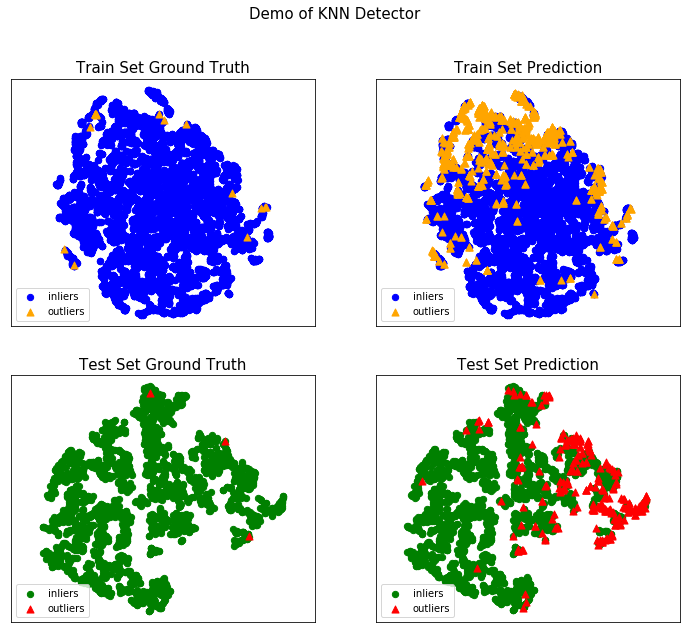

In [13]:
from pyod.utils.example import visualize
visualize(clf_name, X_train_reduced_tsne, y_train, X_test_reduced_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

#### PCA
初始化一个 ``pyod.models.pca.PCA`` 检测器, 模型拟合, 然后给出预测。

In [22]:
# train PCA detector
from pyod.models.pca import PCA

clf_name = 'PCA'
clf = PCA(n_components=3)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

利用 ``ROC`` 和 ``Precision @ Rank`` 评估预测

In [24]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
PCA ROC:0.9621, precision @ rank n:0.5

On Test Data:
PCA ROC:0.8993, precision @ rank n:0.3333


可视化 ``PCA`` 的结果

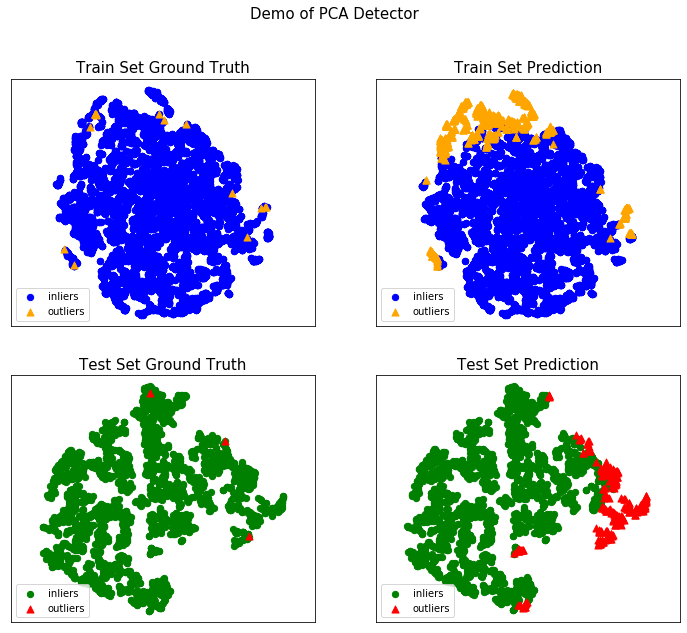

In [20]:
visualize(clf_name, X_train_reduced_tsne, y_train, X_test_reduced_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

#### LOF
初始化一个 ``pyod.models.lof.LOF`` 检测器, 模型拟合, 然后给出预测。

In [32]:
# train LOF detector
from pyod.models.lof import LOF
clf_name = 'LOF'
clf = LOF()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

利用 ``ROC`` 和 ``Precision @ Rank`` 评估预测

In [33]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
LOF ROC:0.9474, precision @ rank n:0.2353

On Test Data:
LOF ROC:0.8031, precision @ rank n:0.0


可视化 ``LOF`` 的结果

In [34]:
# visualize the results
visualize(clf_name, X_train_reduced_tsne, y_train, X_test_reduced_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

ValueError: Input data has to be 2-d for visualization. The input data has (10670, 10).

#### Model Combination
用不同的k(10 ～ 200)初始化20个 ``kNN`` 离群点检测器，然后得到所有的离群点的分数。

In [38]:
from pyod.models.knn import KNN  # kNN detector
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

In [41]:
# standardizing data for processing
X_train_norm, X_test_norm = standardizer(X_train, X_test)

n_clf = 20  # number of base detectors

# initialize 20 base detectors for combination
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

print('Combining {n_clf} kNN detectors'.format(n_clf=n_clf))

for i in range(n_clf):
    k = k_list[i]

    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm)

Combining 20 kNN detectors


In [44]:
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

# Combination by average
y_by_average = average(test_scores_norm)
# Combination by max
y_by_maximization = maximization(test_scores_norm)
# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)

In [55]:
print("\nOn Test Data:")
evaluate_print('Combination by Average', y_test, y_by_average)
evaluate_print('Combination by Maximization', y_test, y_by_maximization)
evaluate_print('Combination by AOM', y_test, y_by_aom)
evaluate_print('Combination by MOA', y_test, y_by_moa)


On Test Data:
Combination by Average ROC:0.925, precision @ rank n:0.0
Combination by Maximization ROC:0.9218, precision @ rank n:0.0
Combination by AOM ROC:0.9211, precision @ rank n:0.0
Combination by MOA ROC:0.9232, precision @ rank n:0.0


In [15]:
m, s = divmod(time.time()-timekeeping, 60)
h, m = divmod(m, 60)
print ('run time: %02d:%02d:%02d' % (h, m, s))

run time: 00:01:38
